# Exercise 4: sWeights and Unfolding

In [1]:
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL
from numba_stats import truncexpon, truncnorm
from resample.bootstrap import variance
from scipy.stats import expon, exponnorm

rng = np.random.default_rng(seed=1)

---

## Task 1: sWeights

A 2D experimental distribution with random variables $(m, t)$ has a signal component 
$$
s(m, t) = s_m(m) s_t(t)
$$
and a background component 
$$
b(m, t) = b_m(m) b_t(t).
$$
The allowed range is $0 < m < 1$ and $0 < t < \infty$.

Let $s_m(m)$ be a Gaussian distribution with mean $\mu_s = 0.5$ and standard deviation $\sigma_s = 0.05$. The distribution $s_t(t)$ is an exponential with $\tau_s = 0.1$. The distribution for $b_m(m)$ is a truncated exponential with $\tau_b = 1$. The distribution for $b_t(t)$ is a truncated Gaussian with mean $\mu_b = 0.2$ and $\sigma_b = 0.2$.

We generate a dataset of pairs $(m, t)$ consisting of $2\,000$ signal events and $10\,000$ background events. A simple way to generate samples from a truncated distribution is to generate too many events first (e.g. twice as many) and then cut the distribution back to the desired range and amount.

---

In [2]:
rng = np.random.default_rng(seed=1)


# to produce truncated distributions, generate more than the cut tails
def generate_s(size):
    m = rng.normal(0.5, 0.05, size=2 * size)
    t = rng.exponential(0.1, size=2 * size)
    mask = (0 < m) & (m < 1) & (t > 0) & (t < 1)
    assert np.sum(mask) >= size
    return m[mask][:size], t[mask][:size]


def generate_b(size):
    m = rng.exponential(1, size=2 * size)
    t = rng.normal(0.2, 0.2, size=2 * size)
    mask = (0 < m) & (m < 1) & (t > 0) & (t < 1)
    assert np.sum(mask) >= size
    return m[mask][:size], t[mask][:size]


n_data_s = 2_000
n_data_b = 10_000

data_s_m, data_s_t = generate_s(n_data_s)
data_b_m, data_b_t = generate_b(n_data_b)

data_m = np.append(data_s_m, data_b_m)
data_t = np.append(data_s_t, data_b_t)

# data has shape (N x 2)
data = np.transpose((data_m, data_t))
del data_m, data_t

---

### 1.1

Plot the 2D distribution of $(m, t)$ separately for the signal and background component, and for both components merged. Plot likewise 1D histograms for the projections along $m$ and $t$.

---

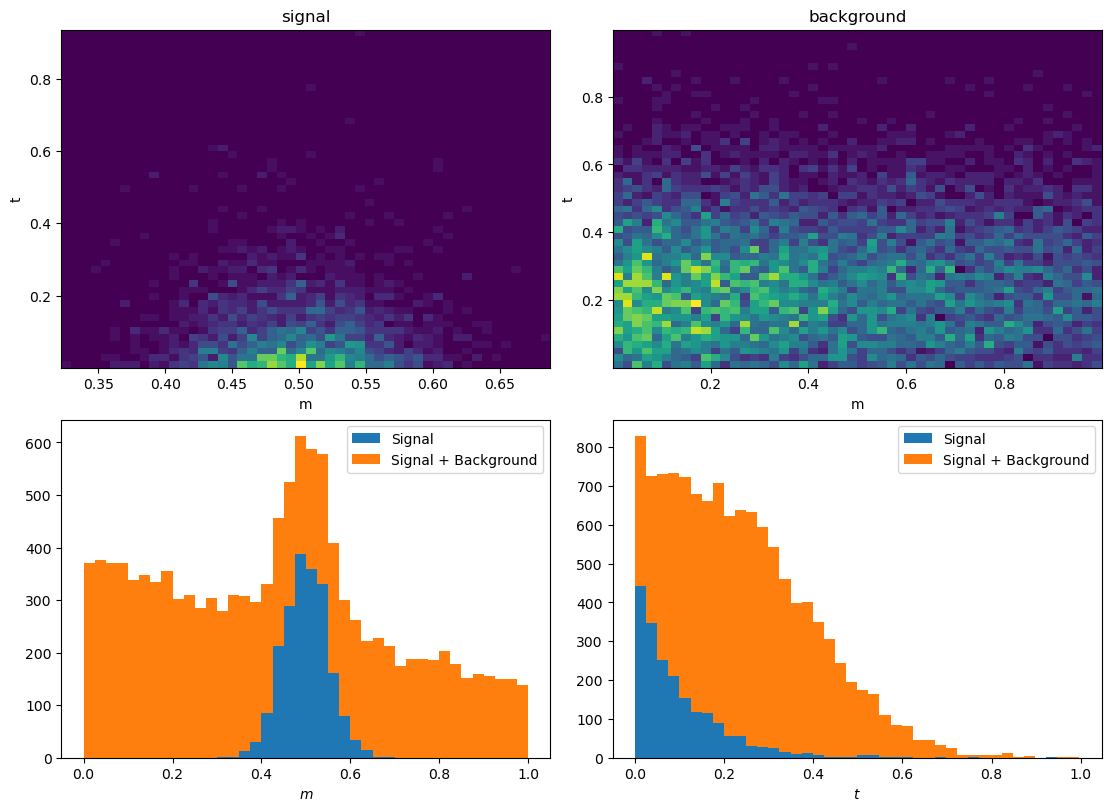

In [3]:
fig, ax = plt.subplots(2, 2, figsize=(2 * 5.5, 2 * 4), layout="constrained")

ax = np.reshape(ax, 4)

ax[0].hist2d(data_s_m, data_s_t, bins=50)
ax[0].set_xlabel("m")
ax[0].set_ylabel("t")
ax[0].set_title("signal")

ax[1].hist2d(data_b_m, data_b_t, bins=50)
ax[1].set_xlabel("m")
ax[1].set_ylabel("t")
ax[1].set_title("background")

ax[2].hist(
    [data_s_m, data_b_m],
    bins=40,
    histtype="barstacked",
    label=["Signal", "Signal + Background"],
)
ax[2].set_xlabel(r"$m$")
ax[2].legend()

ax[3].hist(
    [data_s_t, data_b_t],
    bins=40,
    histtype="barstacked",
    label=["Signal", "Signal + Background"],
)
ax[3].set_xlabel(r"$t$")
ax[3].legend();

---

### 1.2

Fit the mixed distribution in the discriminatory variable $m$ to determine the PDFs and fractions for the signal and background components in the $m$ projection. Assume a truncated gaussian distribution for the signal with unknown parameters $\mu_s$ and $\sigma_s$. Assume a second-order Bernstein polynomial for the background with unknown coefficients.

A second-order Bernstein polynomial for $x \in [0, 1]$ is given by $f(x) = c_1 (1 - x)^2 + 2 c_2 (1 - x) x + c_3 x^2$. See Python implementations below. Bernstein polynomials are ideal for modelling empirical PDFs, because one can guarantee that the polynomial is positive in the domain by requiring $c_i > 0$. This is not the case for other polynomials. One coefficient of the Bernstein polynomial becomes redundant when you compute a normalized PDF. We set $c_1$ = 1 to compensate and fit only $c_2$ and $c_3$.

* Perform the fit with the `iminuit` package, using the `UnbinnedNLL` cost function from `iminuit.cost`.
* Use the `truncnorm` distribution from `numba_stats` to implement the signal PDF.
* Use the `bernstein_pdf` below for the background PDF (it is accelerated with `numba`).
* Normalize the signal and background functions properly to model trunced PDFs.
* Make sure to set appropriate parameter limits in the fit and use good starting values.

---

In [4]:
@nb.njit
def bernstein(x, c1, c2, c3):
    y = 1 - x
    return c1 * y**2 + 2 * c2 * x * y + c3 * x**2


@nb.njit
def bernstein_integral(x, c1, c2, c3):
    y = 1 - x
    return (-c1 * y**3 + c2 * x**2 * (3 - 2 * x) + c3 * x**3) / 3


@nb.njit
def bernstein_pdf(x, c1, c2):
    no = bernstein_integral(1, 1, c1, c2) - bernstein_integral(0, 1, c1, c2)
    return bernstein(x, 1, c1, c2) / no

In [5]:
def pdf_m(m, fs, mu, sigma, c1, c2):
    return fs * truncnorm.pdf(m, 0.0, 1.0, mu, sigma) + (1 - fs) * bernstein_pdf(
        m, c1, c2
    )


c = UnbinnedNLL(data[:, 0], pdf_m)
minuit = Minuit(c, 0.2, 0.5, 0.05, 1, 1)
minuit.limits["fs"] = (0, 1)
minuit.limits["mu"] = (0.2, 0.8)
minuit.limits["sigma"] = (0.01, 0.1)
minuit.limits["c1", "c2"] = (0, None)
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -1910                      │              Nfcn = 148              │
│ EDM = 2.43e-05 (Goal: 0.0002)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ fs    │   0.158   │   0.007   │            │            │    0    │    1    │       │
│ 1 │ mu    │  0.5026   │  0.0020   │            │            │   0.2   │   0.8   │       │
│ 2 │ sigma │  0.0492   │  0.0022   │            │            │  0.01   │   0.1   │       │
│ 3 │ c1    │   0.62    │   0.05    │            │            │    0    │         │       │
│ 4 │ c2    │   0.364   │   0.016   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬──────────────────────────────────────────────┐
│       │       fs       mu    sigma       c1       c2 │
├───────┼──────────────────────────────────────────────┤
│    fs │ 5.23e-05    -0e-6     9e-6 -0.20e-3  0.03e-3 │
│    mu │    -0e-6 4.16e-06    -0e-6    -3e-6    -2e-6 │
│ sigma │     9e-6    -0e-6 4.83e-06   -44e-6     5e-6 │
│    c1 │ -0.20e-3    -3e-6   -44e-6  0.00259 -0.23e-3 │
│    c2 │  0.03e-3    -2e-6     5e-6 -0.23e-3 0.000257 │
└───────┴──────────────────────────────────────────────┘

---

### 1.3 

Compute sWeights and draw them as function of the discriminant variable $m$.

$$
w_s(m) = \frac{W_{bb} \, g_s(m) - W_{sb} \, g_b(m)}{(W_{bb} - W_{sb}) \, g_s(m) + (W_{ss} - W_{sb}) \, g_b(m)}
$$

The $W_{xy}$ are estimated by

$$
\widehat{W}_{xy} = \frac 1 N \sum_i \frac{\hat g_x(m_i) \, \hat g_y(m_i)}{(\hat z \hat g_s(m_i) + (1 - \hat z) \, \hat g_b(m_i))^2}
$$

with signal PDF $g_s$, background PDF $g_b$, and signal fraction $z$.

---

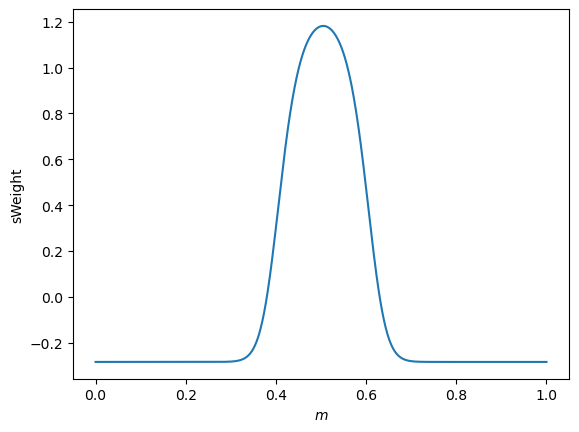

In [6]:
def sweights(z, pdf_s, pdf_b):
    denom = (z * pdf_s + (1 - z) * pdf_b) ** 2
    wss = np.mean(pdf_s**2 / denom)
    wsb = np.mean(pdf_s * pdf_b / denom)
    wbb = np.mean(pdf_b**2 / denom)
    return (wbb * pdf_s - wsb * pdf_b) / ((wbb - wsb) * pdf_s + (wss - wsb) * pdf_b)


def hat_pdf_s(m):
    return pdf_m(m, 1, *minuit.values[1:])


def hat_pdf_b(m):
    return pdf_m(m, 0, *minuit.values[1:])


hat_z = minuit.values["fs"]

m = np.linspace(0, 1, 1000)
sw = sweights(hat_z, hat_pdf_s(m), hat_pdf_b(m))

plt.plot(m, sw, "-")
plt.xlabel("$m$")
plt.ylabel("sWeight");

---

### 1.4

Use sWeights to extract the signal component in the control variable. Use a weighted histogram.

_Hint_: The function `numpy.histogram` with the keyword `weights` is useful here. 

---

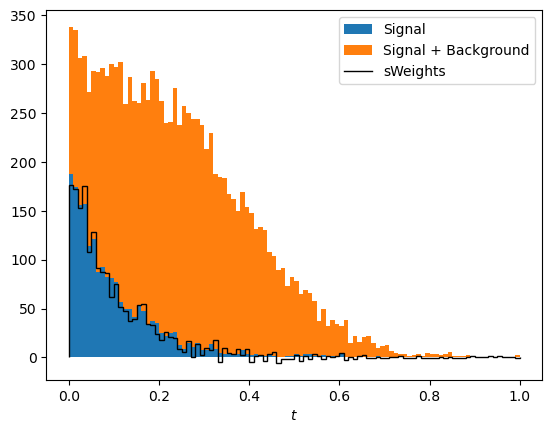

In [7]:
sw = sweights(hat_z, hat_pdf_s(data[:, 0]), hat_pdf_b(data[:, 0]))

w, te = np.histogram(data[:, 1], bins=100, range=(0, 1), weights=sw)

plt.hist(
    [data_s_t, data_b_t],
    bins=te,
    histtype="barstacked",
    label=["Signal", "Signal + Background"],
)
plt.stairs(w, te, color="k", label="sWeights")
plt.xlabel(r"$t$")
plt.legend();

---

### 1.5

Try to extract the signal component in the discriminant variable $m$ with sWeights in the same as in Task 1.4.

Why does this fail?

---

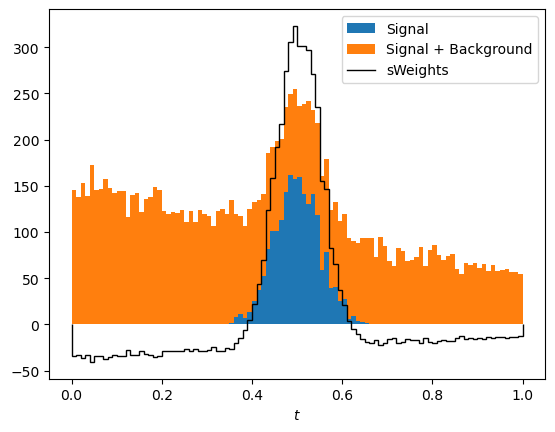

In [8]:
wm, me = np.histogram(data[:, 0], bins=100, range=(0, 1), weights=sw)

plt.hist(
    [data_s_m, data_b_m],
    bins=me,
    histtype="barstacked",
    label=["Signal", "Signal + Background"],
)
plt.stairs(wm, me, color="k", label="sWeights")
plt.xlabel(r"$t$")
plt.legend();

Why it fails: sWeights can only be applied to a variable whose distribution is independent of the discriminatory variable $m$. The $m$ distribution is violating this condition in the maximum possible way and thus applying sWeights fails.

---

## Task 2: Uncertainties of sWeights

Analytical estimates for the uncertainty of the sWeight estimate are derived in [H. Dembinski, M. Kenzie, C. Langenbruch, M. Schmelling, Nucl.Instrum.Meth.A 1040 (2022) 167270](https://doi.org/10.1016/j.nima.2022.167270) and [C. Langenbruch, Eur.Phys.J.C 82 (2022) 5, 393](https://doi.org/10.1140/epjc/s10052-022-10254-8), but their exact calculation is complicated.

A simple but slightly wrong estimate for the variance of a bin is the sum of weights squared in the bin, $V(n_s) = \sum_i w_{s,i}^2$.

A proper estimate is obtained by repeating the full analysis (including the fit to obtain $\hat z$, $\hat g_s$ and $\hat g_b$) on bootstrapped samples.

We will study both methods in the following. But first we compute the expected signal histogram from the true truncated exponential distribution.

---

In [9]:
# te are bin edges that you need to define in your code,
# you get them as the second return value from numpy.histogram
w_true = n_data_s * np.diff(truncexpon.cdf(te, 0, 1, 0, 0.1))

---

### 2.1

Study the residuals of the sWeighted histogram which estimates the signal in $t$ from Task 1.4 with respect to the true expected signal for the histogram in $t$ that we just computed.

Plot a histogram of the residuals divided by an assumed Poisson error. Is the mean compatible with 0? Is the variance close to 1?

---

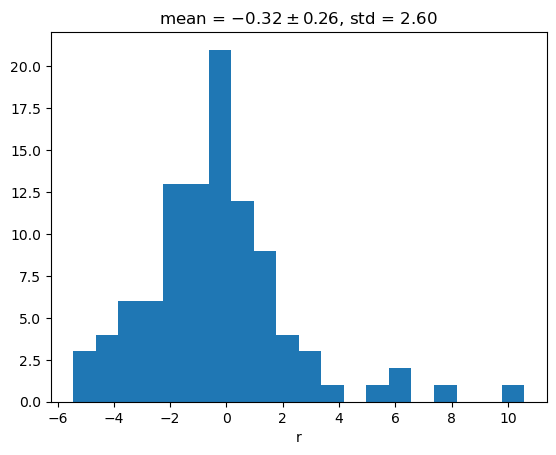

In [10]:
r = (w - w_true) / np.sqrt(w_true)

plt.figure()
plt.hist(r, bins=20)
plt.title(
    f"mean = ${np.mean(r):.2f} \pm {np.std(r) / len(r) ** 0.5:.2f}$,"
    f" std = {np.std(r):.2f}"
)
plt.xlabel("r");